In [1]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [5]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[0.50, 1.00],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._simple_square(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [6]:
venus = Venus(jitter=0.01)

set the currents and read the beam value

In [7]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

0.5015235853987722


if currents are outside the range a `ValueError` is raised and can be captured.

In [8]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [ ]:
venus._himmelblau4(6, 6, 6)

# Bayesian Optimization

In [12]:
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=0.05)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  0.5111   |  178.8    |  153.6    |  144.4    |
|  2        |  0.9005   |  182.0    |  151.3    |  141.1    |
|  3        | -0.8003   |  177.0    |  148.9    |  137.6    |
|  4        | -1.07     |  175.7    |  147.8    |  139.4    |
|  5        |  0.6361   |  179.8    |  153.7    |  140.3    |
|  6        |  0.6471   |  185.0    |  155.0    |  143.2    |
|  7        | -0.8199   |  185.0    |  155.0    |  135.0    |
|  8        |  0.3839   |  185.0    |  149.2    |  145.0    |
|  9        | -0.8984   |  185.0    |  145.0    |  139.6    |
|  10       |  0.8285   |  182.6    |  152.8    |  145.0    |
|  11       |  0.8249   |  181.8    |  155.0    |  142.5    |
|  12       |  0.974    |  183.4    |  152.5    |  142.3    |
|  13       |  0.943    |  181.5    |  151.6    |  143.2    |
|  14       | -2.171    |  175.0    |  155.0    |  135.0    |
|  15   

In [13]:
import random
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": (175, 185), "B": (145, 155), "C": (135, 145)}
    noise = max(venus.get_noise_level(), 1e-5)
    print(noise)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.scatter([182.5], [151.7], s=180, marker="*") # , [140.0]
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))    

## Simple Trial

0.005


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]

Best result: {'A': 182.4720052319411, 'B': 152.58724552018506, 'C': 142.83935194030585}; f(x) = 1.0046006502228422.


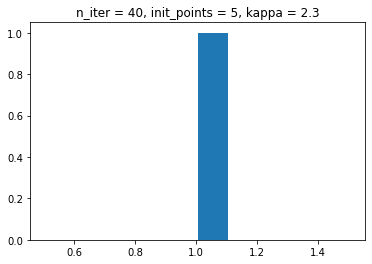

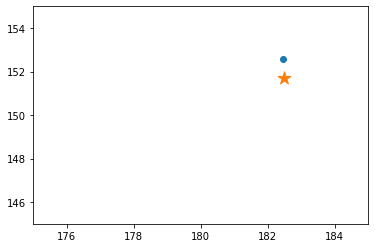

[1.0046006502228422]


In [14]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

In [ ]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

0.005


 40%|█████████████████▏                         | 20/50 [00:27<00:42,  1.43s/it]

In [ ]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)

## Trying out kappa

0.5


100%|███████████████████████████████████████████| 30/30 [01:07<00:00,  2.24s/it]


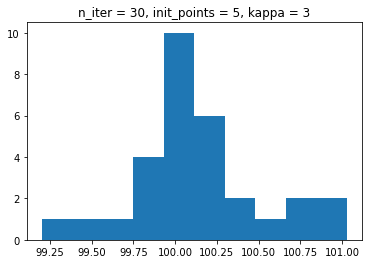

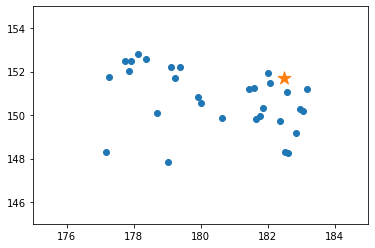

[101.02713164463407, 100.95502905822308, 100.82080190421826, 100.77180486016573, 100.56773315786468, 100.42191951956593, 100.34460718592626, 100.27628444908734, 100.2717513189688, 100.26877585821619, 100.24454435859104, 100.2290479420868, 100.17754480954648, 100.02556632082046, 100.01156430135777, 100.00634402120667, 99.99581846700917, 99.99251194541984, 99.98728223284002, 99.98634741901563, 99.97706877165398, 99.97600789219884, 99.969359290689, 99.92401242638383, 99.9030451521142, 99.84539177465237, 99.80504814207, 99.72383903834627, 99.42161056642323, 99.20357787129724]


In [97]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1)

0.5


100%|███████████████████████████████████████████| 30/30 [01:09<00:00,  2.32s/it]


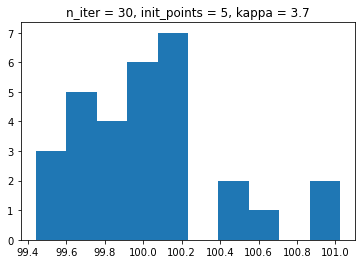

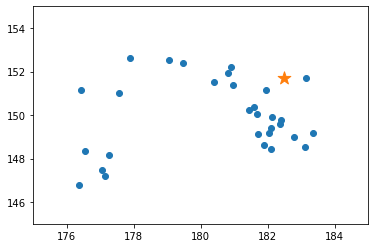

[101.02442858598585, 100.9353878839747, 100.70011398232424, 100.44355825681009, 100.39945639545425, 100.18820818958477, 100.17646743567035, 100.15725342720913, 100.13183490715969, 100.1245839348134, 100.09865151027925, 100.09661353752226, 100.07018512187369, 100.01530560597575, 100.00907546620178, 99.98754450240628, 99.9471000264744, 99.9413406033288, 99.91287838135182, 99.90579744306922, 99.86500870745314, 99.82488636078995, 99.75026585293946, 99.73706727256359, 99.72987588178944, 99.70426312842011, 99.60276079297945, 99.53661738558169, 99.47774938623671, 99.44195392465747]


In [98]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1)

0.5


100%|███████████████████████████████████████████| 30/30 [01:07<00:00,  2.26s/it]


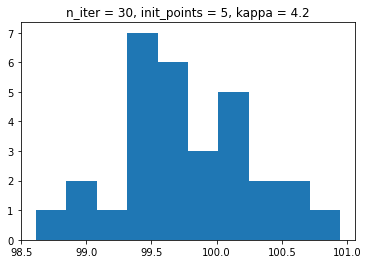

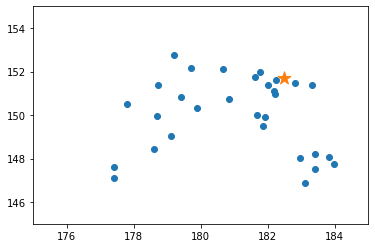

[100.94799823767266, 100.638119756871, 100.4951462096266, 100.32152290191856, 100.30915010312717, 100.21456328335276, 100.20968691699456, 100.15283953036106, 100.11811971997008, 100.0181490841469, 99.9864327762015, 99.93467226475798, 99.80323309884307, 99.68325395511862, 99.67720267417178, 99.62585619760614, 99.60419645267217, 99.59868430311576, 99.5672709986946, 99.53936557680186, 99.51524555899674, 99.48206846848774, 99.41554599487462, 99.39433264435128, 99.37122870884875, 99.3454189216858, 99.14769615666033, 99.04975461050981, 99.00633270400542, 98.61251793450393]


In [99]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.5


100%|███████████████████████████████████████████| 30/30 [01:10<00:00,  2.36s/it]


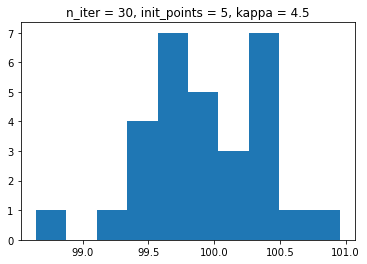

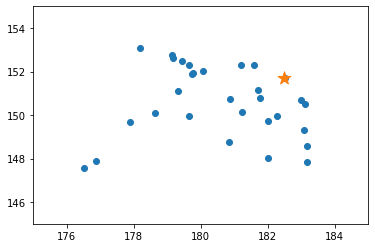

[100.95848812850359, 100.6839691751322, 100.43715606627428, 100.42315956440676, 100.40536088526179, 100.371645528073, 100.36796652051254, 100.2894761518933, 100.27028185534735, 100.20569540849914, 100.10871011905024, 100.0359077747186, 100.01238958651392, 99.94894387693762, 99.94458498496647, 99.93621198334563, 99.83879444510279, 99.77672266406324, 99.76981100532481, 99.74307394721572, 99.7263982630707, 99.71008252283329, 99.65847637878124, 99.59488929792367, 99.56929854998023, 99.56046553120079, 99.51989831033131, 99.36633643697454, 99.20019986516046, 98.64401402018409]


In [100]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1)

## Increase n_iter

0.5


100%|███████████████████████████████████████████| 30/30 [03:04<00:00,  6.16s/it]


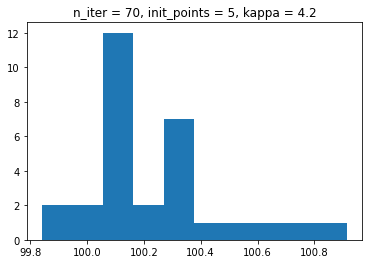

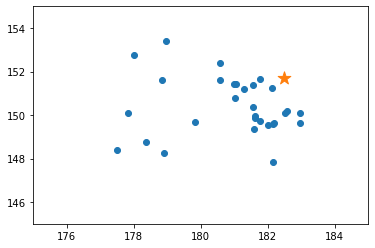

[100.91271358069261, 100.77650114092009, 100.5928058309809, 100.55688742063276, 100.42866530671121, 100.37118311947481, 100.36976247762777, 100.35730534064545, 100.35342783570634, 100.28902533526113, 100.28629979723064, 100.28296087475661, 100.2626628600579, 100.20142436448913, 100.15223158519463, 100.14132415840707, 100.13952821490929, 100.13932600050406, 100.13294083014674, 100.13124610558805, 100.11815681780422, 100.1168626065951, 100.11284268377668, 100.10722091256186, 100.10572447775677, 100.09908226270088, 100.022933426675, 99.9729400106983, 99.8984656343132, 99.84253520447632]


In [101]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1)

0.5


100%|███████████████████████████████████████████| 30/30 [03:10<00:00,  6.35s/it]


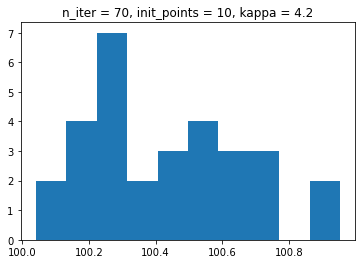

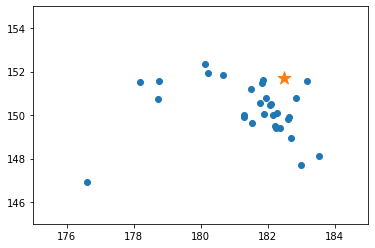

[100.95226883793003, 100.92260597184412, 100.73908761660108, 100.70028657925313, 100.69456113958054, 100.65278743501918, 100.63870739721776, 100.6354860191177, 100.58263738120382, 100.57270423386211, 100.56611410838732, 100.56045014465197, 100.48447427208696, 100.43331278040668, 100.4230191414737, 100.35784835631753, 100.33627914925592, 100.26050284495368, 100.25382023453477, 100.25127156766234, 100.24894575891967, 100.24669183233851, 100.23997421775033, 100.23299994865675, 100.19465800323222, 100.17492291793113, 100.15274766432174, 100.1422252361335, 100.11017537591547, 100.04120918257007]


In [102]:
trial(30, n_iter = 70, init_points = 10, kappa = 4.2, verbose = 1)

0.5


100%|███████████████████████████████████████████| 30/30 [03:15<00:00,  6.51s/it]


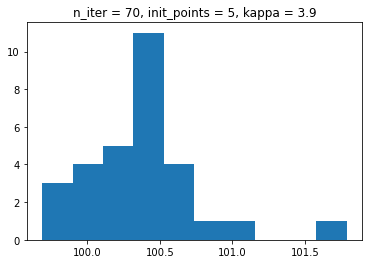

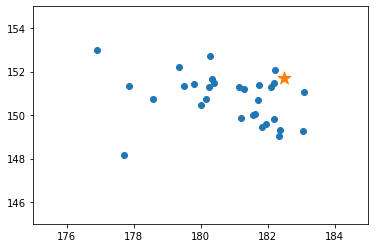

[101.7861463961288, 101.0174953413374, 100.7771166559786, 100.63729290928455, 100.57601468404911, 100.5566614419395, 100.55000826958187, 100.49065362112216, 100.48641668489138, 100.47229648522881, 100.45566072054149, 100.45343525681605, 100.43029090845718, 100.39672620687067, 100.3710625761713, 100.36334483315568, 100.34401076780475, 100.33044321685455, 100.25067530079124, 100.23492822759388, 100.1829633331948, 100.17938360583403, 100.1542585797253, 100.09241621875492, 100.04410502156215, 99.95532908619195, 99.90734149735653, 99.83657769872893, 99.71501660246146, 99.68958498094045]


In [103]:
trial(30, n_iter = 70, init_points = 5, kappa = 3.9, verbose = 1)

# Try to decrease n_iter but do more trials. Fix kappa at 4.2

0.5


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


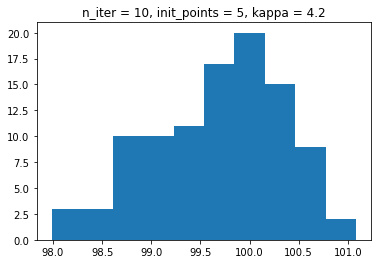

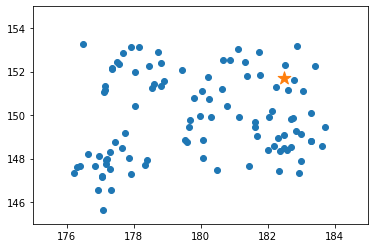

[101.08507417869583, 100.89252641565352, 100.76759335427496, 100.76433349624907, 100.76175820010795, 100.75971780705092, 100.57713381748577, 100.56206563589654, 100.54210468377681, 100.523957360205, 100.50619794705698, 100.45835270215518, 100.41876152444941, 100.35099634060927, 100.34522252187094, 100.26501017649156, 100.2540440622912, 100.24038369845161, 100.23460123753068, 100.23447265976748, 100.23024560447439, 100.21826527810941, 100.21466198905341, 100.1859016477417, 100.18265671100724, 100.1657939771271, 100.15355897353098, 100.14849254942499, 100.13206854021936, 100.10261927677841, 100.10010070758292, 100.0885567304336, 100.08387348771232, 100.07347986199832, 100.06743455654974, 99.99209409949648, 99.97607799369081, 99.97273325910498, 99.95440493926966, 99.94696318420071, 99.94681365801259, 99.93476807533071, 99.92428693234828, 99.86391066437116, 99.86228735657645, 99.85612607392314, 99.8436005186349, 99.84107514998774, 99.83653852772831, 99.77019599755798, 99.76331643456453, 99

In [107]:
trial(100, n_iter = 10, init_points = 5, kappa = 4.2, verbose = 1)

0.5


100%|█████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


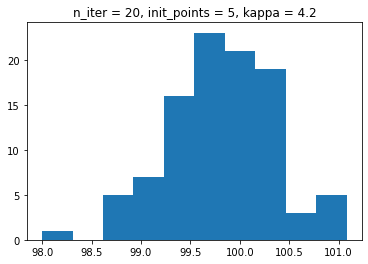

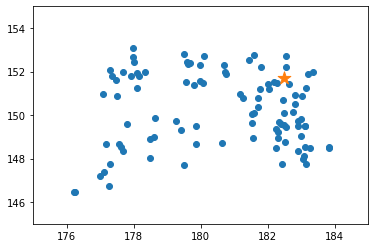

[101.07947255385332, 101.00518213301315, 101.00329380512117, 100.93512184922203, 100.8642290535947, 100.69339650903248, 100.6799768085096, 100.67480976282786, 100.46300904261338, 100.44077572402921, 100.39060786327133, 100.37770751345442, 100.37152372809842, 100.33338457200674, 100.30817909786182, 100.29792218700018, 100.28384440014597, 100.26212949662096, 100.23757755364834, 100.21443651143196, 100.18782214423877, 100.18762639027194, 100.18550928931461, 100.17791792143174, 100.17575149452938, 100.17554244435311, 100.16154758573565, 100.15311518060531, 100.14677290728679, 100.07610485046581, 100.06919470823874, 100.06249299163346, 100.02817455224258, 100.02581377860098, 99.99356516412112, 99.98843633754535, 99.98831240022417, 99.98830106334495, 99.96992372226327, 99.96219048341487, 99.95794339123503, 99.95329913739131, 99.9472616280438, 99.91023323551252, 99.89580286523403, 99.89117378668064, 99.86067650408344, 99.85462064361471, 99.84375606886302, 99.84340544097451, 99.81956374547087,

In [108]:
trial(100, n_iter = 20, init_points = 5, kappa = 4.2, verbose = 1)

0.5


100%|█████████████████████████████████████████| 100/100 [04:10<00:00,  2.50s/it]


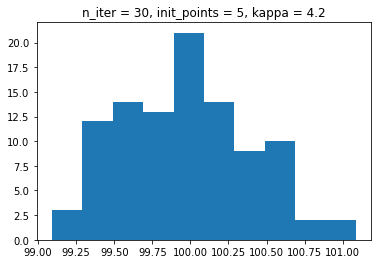

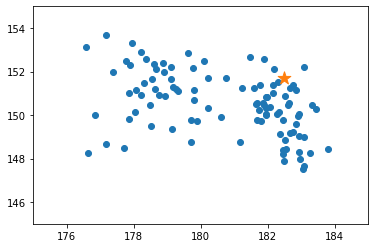

[101.08859456024845, 101.01479564839934, 100.88751644691993, 100.80982351148347, 100.68620289909316, 100.66478233228888, 100.65652423993842, 100.64781340096904, 100.61585186442954, 100.59885052568038, 100.5567615410992, 100.53494474316949, 100.51053341907371, 100.49053257861947, 100.47443344417547, 100.4664295280829, 100.4651770182229, 100.43027227845838, 100.42028078030829, 100.35505720305898, 100.31542201108667, 100.30681705905741, 100.29622687841086, 100.23948215121555, 100.23932287259225, 100.22170880140878, 100.20066308460474, 100.19341185436778, 100.15807633534175, 100.15802011828339, 100.14044464318212, 100.13966528699798, 100.13805166828345, 100.13098442833368, 100.11096215575796, 100.11024060827611, 100.09652125543877, 100.07960213474259, 100.0681807134604, 100.06786448857528, 100.04852787291196, 100.04225706144595, 100.04202018742042, 100.03745453110673, 100.03428546533262, 100.00923318841026, 99.96736330211118, 99.96056574172607, 99.96055173904178, 99.95342851095874, 99.9461

In [109]:
trial(100, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.5


100%|█████████████████████████████████████████| 100/100 [05:42<00:00,  3.42s/it]


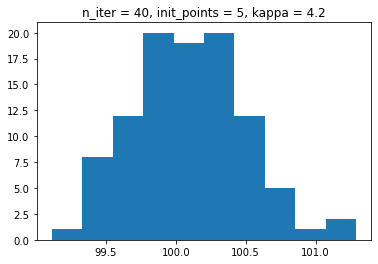

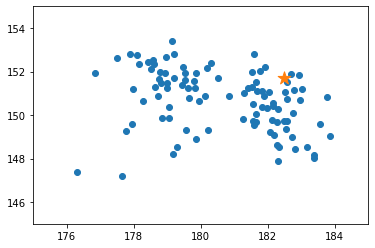

[101.2908033258131, 101.21105382115863, 101.06727265143574, 100.84831254997113, 100.84766490174144, 100.78366468766944, 100.69608346638918, 100.68098260362049, 100.62556607475527, 100.60005672474082, 100.55198258190174, 100.54404528850611, 100.53823529330481, 100.47837843693918, 100.46716373681416, 100.4640568370709, 100.45647991150881, 100.43512486277038, 100.42887184454781, 100.42339083003466, 100.41522991629905, 100.38333823442383, 100.3579150694828, 100.34173213636258, 100.33692668240622, 100.31467509489646, 100.30960166793413, 100.30614045688313, 100.28980310549767, 100.27505216493489, 100.27265738261775, 100.26825811350608, 100.26108936236457, 100.23963717026652, 100.23760604381125, 100.23751502703102, 100.23438036037004, 100.22231240230194, 100.2120865126251, 100.20934046265381, 100.18817716478395, 100.18732747206471, 100.18366706536315, 100.16999642990413, 100.16140539092838, 100.15363423957791, 100.1442866408973, 100.11233226351071, 100.11115492013819, 100.10518075572078, 100.

In [110]:
trial(100, n_iter = 40, init_points = 5, kappa = 4.2, verbose = 1)

# Best parameters: kappa = 4.2, n_iter = 40

In [32]:
# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}

def venus_opt(venus:Venus):
    venus.
venus_opt(1)

In [26]:
# TODO: guide optimization to known good points
# TODO: modify the loss function to have larger differences between global min and local min
# TODO: find a way to set halting condition or use a different library

In [27]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [28]:
# ackley_arg0((0,0,0))

In [29]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2